In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
class KMeans:
    """
    KMeans class for performing KMeans clustering.

    Args:
    - data (numpy.ndarray): Input data for clustering.

    Methods:
    - compute_euclidean_distance(a, b): Compute Euclidean distance between two points.
    - initial_selection(k): Initialize centroids randomly.
    - assign_cluster_ids(centroids): Assign cluster IDs to each data point based on nearest centroids.
    - compute_cluster_representatives(cluster_ids, k): Compute new centroids based on cluster assignments.
    - silhouette_coefficient(cluster_ids, k): Compute silhouette coefficient for a given clustering.
    - cluster_name(k, max_iter=100): Perform clustering and return cluster IDs for each data point.
    """
    def __init__(self, data):
        """
        Initialize KMeans object with input data.

        Args:
        - data (numpy.ndarray): Input data for clustering.
        """
        self.data = data

    def compute_euclidean_distance(self, a, b):
        """
        Compute Euclidean distance between two points.

        Args:
        - a (numpy.ndarray): First point.
        - b (numpy.ndarray): Second point.

        Returns:
        - float: Euclidean distance between points a and b.
        """
        return np.linalg.norm(a - b)

    def initial_selection(self, k):
        """
        Initialize centroids randomly.

        Args:
        - k (int): Number of clusters.

        Returns:
        - numpy.ndarray: Initial centroids.
        """
        np.random.seed(42) # Fixing seed for reproducibility
        indices = np.random.choice(self.data.shape[0], k, replace=False)
        return self.data[indices]

    def assign_cluster_ids(self, centroids):
        """
        Assign cluster IDs to each data point based on nearest centroids.

        Args:
        - centroids (numpy.ndarray): Centroids of clusters.

        Returns:
        - numpy.ndarray: Cluster IDs for each data point.
        """
        cluster_ids = np.zeros(self.data.shape[0])
        for i, point in enumerate(self.data):
            distances = [self.compute_euclidean_distance(point, centroid) for centroid in centroids]
            cluster_ids[i] = np.argmin(distances)
        return cluster_ids

    def compute_cluster_representatives(self, cluster_ids, k):
        """
        Compute new centroids based on cluster assignments.

        Args:
        - cluster_ids (numpy.ndarray): Cluster IDs for each data point.
        - k (int): Number of clusters.

        Returns:
        - numpy.ndarray: New centroids.
        """
        centroids = np.zeros((k, self.data.shape[1]))
        for cluster_id in range(k):
            cluster_points = self.data[cluster_ids == cluster_id]
            centroids[cluster_id] = np.mean(cluster_points, axis=0)
        return centroids

    def silhouette_coefficient(self, cluster_ids, k):
        """
        Compute silhouette coefficient for a given clustering.

        Args:
        - cluster_ids (numpy.ndarray): Cluster IDs for each data point.
        - k (int): Number of clusters.

        Returns:
        - float: Silhouette coefficient.
        """
        silhouette_values = []
        for i, point in enumerate(self.data):
            cluster_id = int(cluster_ids[i])
            a = np.mean([self.compute_euclidean_distance(point, self.data[j]) for j in range(len(self.data)) if cluster_ids[j] == cluster_id])
            b_values = [np.mean([self.compute_euclidean_distance(point, self.data[j]) for j in range(len(self.data)) if cluster_ids[j] == other_cluster_id]) for other_cluster_id in range(k) if other_cluster_id != cluster_id]
            b = min(b_values) if b_values else 0
            silhouette_values.append((b - a) / max(a, b))
        return np.mean(silhouette_values)

    def cluster_name(self, k, max_iter=100):
        """
        Perform clustering and return cluster IDs for each data point.

        Args:
        - k (int): Number of clusters.
        - max_iter (int): Maximum number of iterations for convergence.

        Returns:
        - numpy.ndarray: Cluster IDs for each data point.
        """
        centroids = self.initial_selection(k)
        for _ in range(max_iter):
            cluster_ids = self.assign_cluster_ids(centroids)
            new_centroids = self.compute_cluster_representatives(cluster_ids, k)
            if np.all(centroids == new_centroids):
                break
            centroids = new_centroids
        return cluster_ids

In [7]:
def load_data(fname):
    """
    Load data from a file.

    Args:
    - fname (str): File name/path containing data.

    Returns:
    - numpy.ndarray: Loaded data.
    """
    features = []
    try:
        with open(fname) as F:
            next(F)  # skip the first line with feature names
            for line in F:
                p = line.strip().split()
                features.append(np.array([float(x) for x in p[1:]]))
    except FileNotFoundError:
        raise FileNotFoundError(f"File '{fname}' not found.")
    except ValueError:
        raise ValueError(f"File '{fname}' is corrupted or has invalid data format.")

    if len(features) <= 1:
        raise ValueError("File must contain at least 2 data points for clustering.")

    return np.array(features)


def compute_sum_of_squares(data, cluster_ids, centroids):
    """
    Compute the sum of squared distances within a cluster.

    Args:
    - data (numpy.ndarray): The input data points.
    - cluster_ids (numpy.ndarray): Cluster IDs for each data point.
    - centroids (numpy.ndarray): Centroids of clusters.

    Returns:
    - float: The sum of squared distances within the clusters.
    """
    sum_of_squares = 0
    for i, point in enumerate(data):
        centroid = centroids[int(cluster_ids[i])]
        sum_of_squares += np.sum((point - centroid)**2)
    return sum_of_squares

def bisect_k_means(data, k):
    """
    Implements the Bisecting k-Means algorithm.

    Args:
    - data (numpy.ndarray): The input data points.
    - k (int): The desired number of clusters.

    Returns:
    - list: A list of cluster IDs for each data point after bisecting.
    """
    clusters = [np.arange(len(data))]  # Initial single cluster
    while len(clusters) < k:
        # Find the cluster with the largest sum of squares
        max_ss_cluster = None
        max_ss = float('-inf')
        for cluster_id in clusters:
            cluster_data = data[cluster_id]
            kmeans = KMeans(cluster_data)
            cluster_ids = kmeans.cluster_name(2)
            centroids = kmeans.compute_cluster_representatives(cluster_ids, 2)
            ss = compute_sum_of_squares(cluster_data, cluster_ids, centroids)
            if ss > max_ss:
                max_ss = ss
                max_ss_cluster = cluster_id

        # Bisect the cluster with the largest sum of squares
        cluster_data = data[max_ss_cluster]
        kmeans = KMeans(cluster_data)
        cluster_ids = kmeans.cluster_name(2)
        clusters = [c for c in clusters if not np.array_equal(c, max_ss_cluster)]
        clusters.extend([max_ss_cluster[cluster_ids == i] for i in range(2)])

    return clusters

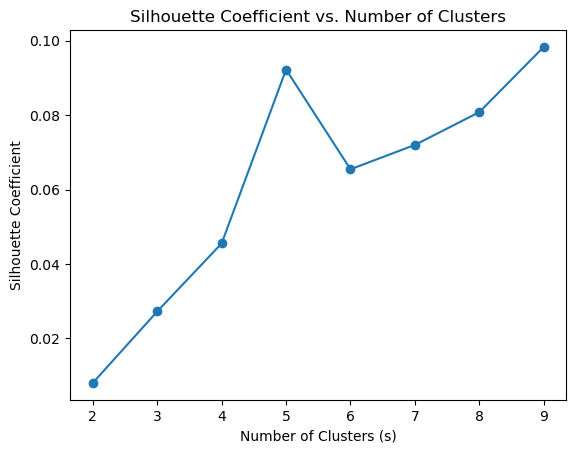

Silhouette plot saved in the current directory.


In [8]:
def main():
    """
    Main function to execute Bisecting K-Means clustering and plot Silhouette Coefficient.
    """
    data = load_data("dataset")
    k = 9

    clusters = bisect_k_means(data, k)

    kmeans = KMeans(data)
    silhouette_scores = []
    for s in range(2, k + 1):  # Starting at 2 for plotting
        cluster_ids = np.zeros(len(data))
        for i, cluster in enumerate(clusters[:s]):
            cluster_ids[cluster] = i

        silhouette_scores.append(kmeans.silhouette_coefficient(cluster_ids, s))

    plt.plot(range(2, k + 1), silhouette_scores, marker='o')  # Starting at 2 for plotting
    plt.xlabel("Number of Clusters (s)")
    plt.ylabel("Silhouette Coefficient")
    plt.title("Silhouette Coefficient vs. Number of Clusters")
    plt.savefig("BisectingKMeans.png")
    plt.show()
    print(f"Silhouette plot saved in the current directory.")
    
if __name__ == "__main__":
    main()